# Реализация детекции текста с помощью модели Fast-RCNN

In [1]:
import os
import PIL
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

from torch.utils.tensorboard import SummaryWriter

In [3]:
from MyDataset import MyDataset

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor,MaskRCNN


      
def get_instance_segmentation_model(num_classes) -> MaskRCNN:
    # load an instance segmentation model pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=False,num_classes = num_classes)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    #in_features_mask = model.roi_heads.box_predictor.cls_score.in_channels
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    #model.roi_heads.box_predictor = MaskRCNNPredictor(in_features_mask,
                                                      #in_features, num_classes)

    # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
    #                                                    hidden_layer,
    #                                                    num_classes)
    model.roi_heads.mask_predictor  = None

    return model

In [5]:
from common.engine import train_one_epoch
from common import utils
import common.transforms as T


def get_transform(train):
    transforms = []
    #transforms.Lambda(lambda image: image.convert("RGB")),
    #transforms.ConvertImageDtype(torch.float),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # converts the image, a PIL image, into a PyTorch Tensor
    #transforms.append(T.torchvision.transforms.PILToTensor())
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
# conf_train = [{
#         'fonts':['TextRecognitionDataGenerator/tests/font.ttf']
#         , 'texts':['Привет Мир!!!!\nПока мир!\nввв','dfdsfsd','вот так']
#         , 'text_colors':['#00ffff','#ff0000','#ffff00']
#         , 'size_images':[(280,280),(512,512)]
#         , 'position_texts':[(20,40),(2,4),(10,4),(4,10),(40,50)]
#         , 'font_sizes':[32,16,10]
#         , 'background_colors':['#000000','#ffffff']
#     }]

from train_config_400_1 import configuration as conf_train
from test_config_400_1 import configuration as conf_test

dataset = MyDataset(conf_train, get_transform(train=True))
dataset_test = MyDataset(conf_test, get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for d in data_loader:
    break

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
#не сработало:
# optimizer = torch.optim.Adam(params, lr=0.005,
#                             weight_decay=0.0005)
#не сработало:
#optimizer = torch.optim.Adam(params, lr=0.05)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# let's train it for 10 epochs
num_epochs = 100

writer = SummaryWriter('data_1')

def collback_loss(loss_value,step):
    #print(f'{loss_value=}')
    writer.add_scalar('Loss/trainSGD100', loss_value,step)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10,collback_loss=collback_loss)
    # update the learning rate
    lr_scheduler.step()
    
writer.close()

2023-03-05 20:48:01.962124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 20:48:02.476613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-05 20:48:02.476665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-05 20:48:02.476671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Epoch: [0]  [  0/333]  eta: 0:16:01  lr: 0.000020  loss: 5.4429 (5.4429)  loss_classifier: 0.6248 (0.6248)  loss_box_reg: 0.6558 (0.6558)  loss_objectness: 3.8864 (3.8864)  loss_rpn_box_reg: 0.2759 (0.2759)  time: 2.8862  data: 1.4011  max mem: 1624
Epoch: [0]  [ 10/333]  eta: 0:02:36  lr: 0.000170  loss: 3.3448 (3.4389)  loss_classifier: 0.5697 (0.5702)  loss_box_reg: 0.6522 (0.6150)  loss_objectness: 1.9987 (1.9752)  loss_rpn_box_reg: 0.2759 (0.2784)  time: 0.4860  data: 0.1286  max mem: 1962
Epoch: [0]  [ 20/333]  eta: 0:01:56  lr: 0.000321  loss: 1.8305 (2.6063)  loss_classifier: 0.4858 (0.5153)  loss_box_reg: 0.7008 (0.6713)  loss_objectness: 0.2890 (1.1577)  loss_rpn_box_reg: 0.2506 (0.2620)  time: 0.2450  data: 0.0018  max mem: 1962
Epoch: [0]  [ 30/333]  eta: 0:01:40  lr: 0.000471  loss: 1.4868 (2.1949)  loss_classifier: 0.4154 (0.4581)  loss_box_reg: 0.7849 (0.7046)  loss_objectness: 0.1161 (0.8101)  loss_rpn_box_reg: 0.1887 (0.2220)  time: 0.2451  data: 0.0023  max mem: 1962


KeyboardInterrupt: 

In [9]:
torch.cuda.empty_cache()

In [10]:
torch.save(model.state_dict(), 'model_1.mw')

In [11]:
!ls -s model_1.mw

161848 model_1.mw


In [12]:
to_image = torchvision.transforms.ToPILImage()
import matplotlib.pyplot as plt
import cv2
import numpy as np

predict=[{'boxes': tensor([[166.7644, 129.7042, 195.3649, 144.6321],
        [127.6779, 167.1982, 163.2670, 182.3782],
        [135.4541,  16.7771, 172.0307,  30.2865],
        [122.9941, 130.1956, 161.7969, 145.4024],
        [ 50.3489,  16.2605,  92.7646,  29.6402],
        [ 97.2532,  16.5397, 130.0694,  31.4531],
        [ 50.9447,  84.4856,  85.9510,  98.7990],
        [165.5853,  83.6581, 203.3573,  98.5957],
        [ 51.0615,  67.1845,  93.4078,  82.1158],
        [ 91.1209,  32.7064, 121.7010,  46.4353],
        [ 99.6444,  66.5453, 139.1139,  81.7219],
        [188.8055,  67.0919, 230.6694,  81.1820],
        [144.3091,  66.8809, 183.7279,  82.1968],
        [ 51.0835, 167.9470, 121.2277, 182.8932],
        [ 51.0907, 148.7502,  90.9096, 163.7036],
        [ 84.9781, 129.8834, 116.8304, 144.5401],
        [ 51.1377,  50.1992,  90.7592,  64.8197],
        [ 93.8326,  84.4544, 158.2141, 100.4383],
        [ 49.8130, 129.6273,  79.8090, 144.8486],
        [ 50.8005, 101.3368,  8

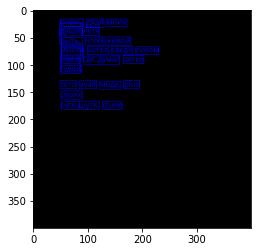

predict=[{'boxes': tensor([[135.5510,  16.5423, 172.2413,  30.3705],
        [ 50.5746,  16.2631,  93.0096,  29.9213],
        [ 94.6164,  84.4909, 160.0639, 100.4378],
        [166.8338, 129.6084, 195.6640, 144.6120],
        [123.4326, 130.1299, 162.1786, 145.8913],
        [ 97.4624,  16.5771, 130.2120,  31.5409],
        [ 50.9839,  67.4873,  93.4404,  82.3403],
        [ 50.5225,  84.6457,  86.4671,  98.7315],
        [ 50.8645,  50.1928,  90.4507,  65.2119],
        [ 99.5368,  66.5830, 138.8482,  82.2069],
        [144.2183,  66.7404, 183.7099,  82.3699],
        [165.0672,  83.8878, 203.5499,  98.6401],
        [ 84.8196, 129.5019, 116.9338, 144.3592],
        [ 50.6032, 148.7882,  91.2831, 163.9393],
        [ 49.7837,  33.0960,  87.6391,  47.5985],
        [188.0141,  67.1702, 230.7255,  81.4817],
        [127.6514, 167.6154, 163.6199, 182.1749],
        [ 91.1559,  32.5947, 121.6860,  46.9067],
        [ 49.6178, 129.3889,  80.0562, 144.7447],
        [ 50.8759, 101.2573,  8

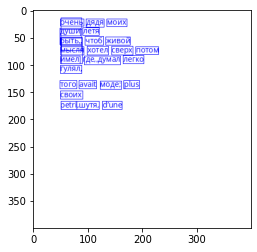

predict=[{'boxes': tensor([[135.1498,  16.8968, 172.3551,  30.1699],
        [ 49.4160,  16.5350,  92.2591,  29.2994],
        [ 50.0745,  50.3164,  90.6630,  64.4076],
        [ 96.9801,  16.6992, 129.7704,  31.0866],
        [ 50.6212,  67.4843,  93.6622,  81.8213],
        [ 95.4467,  84.5786, 160.3668,  99.8073],
        [ 48.5159, 168.5028, 122.5491, 182.5409],
        [123.7600, 130.6257, 162.5339, 145.4250],
        [166.4130, 129.9957, 195.5361, 144.1225],
        [ 49.5608, 129.7271,  80.5901, 144.2722],
        [ 90.9198,  32.3781, 121.8828,  46.2259],
        [164.9683,  84.1991, 202.7867,  98.0866],
        [ 85.4004, 130.1338, 116.4115, 143.6099],
        [ 50.4493,  84.6229,  85.9559,  98.2574],
        [ 49.3193,  32.9533,  86.8732,  46.9324],
        [ 50.7373, 101.2609,  90.1700, 115.6102],
        [143.6690,  66.9925, 183.6486,  81.5640],
        [ 50.5905, 148.9609,  90.2991, 163.5607],
        [ 99.6092,  66.6515, 138.5964,  82.1479],
        [188.1679,  67.4823, 22

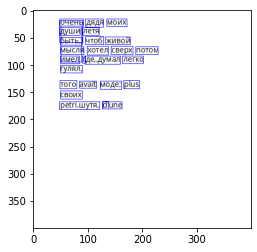

predict=[{'boxes': tensor([[134.6565,  17.1899, 172.2296,  30.1889],
        [ 49.5436,  16.7896,  93.0762,  29.7733],
        [166.8545, 130.0218, 195.6957, 144.1313],
        [ 96.0826,  84.8615, 160.9693,  99.8299],
        [ 96.8933,  16.9847, 130.1258,  31.4046],
        [123.2244, 130.8553, 162.6422, 145.6508],
        [164.6253,  84.6554, 203.3533,  97.9542],
        [ 90.9100,  32.5936, 122.0779,  46.1172],
        [ 50.3746,  67.7794,  93.8783,  82.0995],
        [ 84.4794, 130.2007, 117.1846, 144.1374],
        [ 50.7456,  50.4386,  90.6864,  64.9247],
        [ 50.1814,  84.8858,  86.0754,  98.4421],
        [ 49.4190,  33.0729,  87.5954,  46.9292],
        [ 50.1807, 101.5833,  89.9161, 115.5231],
        [126.9762, 168.1363, 163.7055, 181.9495],
        [ 49.4468, 130.0717,  79.5724, 144.3366],
        [ 49.6505, 168.3765, 122.2752, 182.5041],
        [188.8934,  67.6343, 231.4425,  81.3962],
        [ 95.8944,  49.0643, 128.9421,  64.0586],
        [144.6943,  67.0179, 18

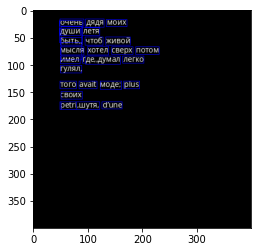

predict=[{'boxes': tensor([[133.1856,  92.0904, 176.3192, 106.3339],
        [171.5761, 148.2175, 206.6498, 163.2910],
        [100.1885,  34.6021, 135.2715,  48.7960],
        [ 49.6062, 109.9423,  79.7339, 126.1883],
        [ 95.7453, 186.5853, 137.5844, 201.3869],
        [ 94.2957,  92.6866, 128.2746, 106.7629],
        [ 94.7452, 148.5853, 134.1660, 163.5076],
        [ 51.0307, 129.8988,  92.9604, 144.9651],
        [ 95.7487, 166.4978, 127.2353, 182.8957],
        [132.0386, 168.1846, 166.2219, 183.1687],
        [ 49.9394, 187.0066,  90.2907, 202.3826],
        [ 49.3867,  35.5650,  95.0801,  49.5310],
        [ 51.0382, 148.3433,  88.2900, 163.9850],
        [139.7409, 148.5609, 167.1499, 164.3499],
        [ 50.2913,  92.7736,  86.5361, 106.4669],
        [ 85.0275, 110.7969, 126.3315, 126.3102],
        [ 50.7605, 167.1626,  89.4972, 183.5491],
        [ 50.4077, 133.2204,  89.1312, 198.7952]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1,

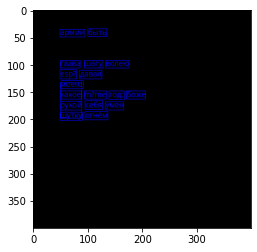

predict=[{'boxes': tensor([[171.5770, 148.3699, 207.0020, 163.5629],
        [ 95.1972, 186.6465, 137.1913, 201.5754],
        [133.5006,  92.2785, 177.0942, 106.0280],
        [131.8512, 168.4842, 166.1742, 183.1316],
        [ 51.0946, 129.6070,  93.4414, 144.9406],
        [ 94.5325, 148.4660, 133.9552, 163.9806],
        [ 50.0867, 110.0205,  80.3186, 126.3326],
        [ 94.5502,  92.5441, 128.1854, 107.1346],
        [ 49.5509, 186.8720,  90.5288, 202.7010],
        [100.4419,  35.0174, 135.6811,  48.7213],
        [ 95.8425, 166.9827, 127.0298, 183.1106],
        [ 49.5272,  35.8250,  95.0653,  49.5654],
        [ 50.8906, 148.2269,  87.9280, 164.5213],
        [ 50.8917, 167.7047,  89.2778, 183.9799],
        [ 50.9637,  92.9500,  86.9603, 106.4254],
        [140.4461, 148.7665, 166.9439, 164.5957],
        [ 85.3694, 110.9386, 125.2282, 126.3632],
        [ 50.3518, 131.5150,  88.8793, 199.5608],
        [ 51.3510, 116.6365,  90.0069, 167.9348]], device='cuda:0',
       grad_f

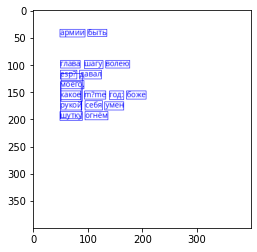

predict=[{'boxes': tensor([[ 51.3824, 129.5874,  94.8608, 144.2691],
        [132.0930, 168.6744, 166.6080, 182.3287],
        [ 93.9579, 149.0156, 133.6863, 163.4942],
        [133.2675,  92.5690, 177.0780, 105.6267],
        [ 94.2166,  92.8059, 128.4077, 106.5594],
        [ 95.6974, 166.9082, 126.3673, 182.2726],
        [170.8156, 148.7311, 207.3437, 162.7802],
        [ 48.7554,  36.2557,  94.7551,  49.0521],
        [ 51.9489,  93.4256,  87.1413, 105.8130],
        [ 50.1176, 110.6414,  79.9055, 125.8768],
        [100.3493,  35.2536, 135.8223,  48.2340],
        [ 50.1452, 167.9007,  88.7196, 183.6676],
        [ 94.4749, 186.9306, 137.0515, 201.0783],
        [ 85.3581, 111.3502, 125.6844, 125.9249],
        [ 50.4590, 148.2209,  87.5708, 163.7100],
        [140.5313, 149.3952, 167.3507, 164.2490],
        [ 50.6305, 186.9789,  89.7426, 202.2119],
        [ 50.8275, 140.1603,  87.0207, 197.5607],
        [ 50.7468,  93.0222,  85.9780, 158.7383]], device='cuda:0',
       grad_f

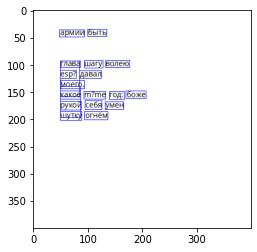

predict=[{'boxes': tensor([[132.7346,  92.7893, 176.8974, 105.6212],
        [ 95.0205, 187.0110, 137.1319, 201.2025],
        [101.0518,  34.8738, 136.0388,  48.4608],
        [131.4407, 168.9567, 166.7146, 182.4182],
        [ 93.7199, 149.2750, 134.0403, 163.0807],
        [ 49.3413,  36.2839,  96.0106,  49.4385],
        [ 93.5246,  92.9932, 128.5341, 106.5366],
        [ 50.0621, 110.4057,  79.4858, 125.8162],
        [171.5383, 148.8671, 207.4079, 162.9132],
        [ 49.2445, 187.5600,  90.4407, 202.1859],
        [ 51.5257,  93.5770,  87.5754, 105.7274],
        [ 95.7818, 166.9031, 126.9130, 182.0954],
        [ 50.9895, 129.9130,  94.3592, 144.5035],
        [ 85.0519, 111.5836, 125.9922, 125.7252],
        [ 50.3614, 148.7106,  88.2141, 163.4886],
        [ 50.0878, 167.7533,  88.7547, 183.4942],
        [139.6843, 149.2207, 166.8649, 163.9193],
        [ 50.6652, 136.7832,  88.0011, 197.8079]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1,

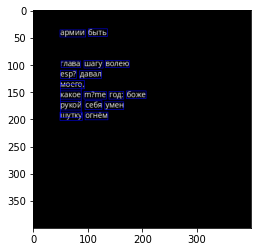

predict=[{'boxes': tensor([[ 96.6453,  15.5009, 128.9663,  30.3159],
        [ 98.8136,  91.9333, 129.4751, 106.9676],
        [137.5164, 186.9689, 172.4824, 201.2535],
        [133.9256,  16.7970, 173.4001,  30.8430],
        [ 50.6436,  15.8437,  90.6914,  30.4967],
        [ 50.1770,  33.8449,  81.2577,  49.4594],
        [ 83.7345,  52.8598, 116.2025,  69.0826],
        [ 88.7596, 167.3071, 117.0183, 182.5024],
        [ 92.4119, 187.2129, 131.7838, 201.8956],
        [178.2069, 149.1169, 222.7541, 163.4168],
        [ 49.6055, 187.2566,  86.5020, 202.2003],
        [ 50.3062, 148.0556,  81.5445, 164.2335],
        [ 49.2188, 110.4695,  75.1089, 125.4219],
        [ 50.8252, 130.0082,  92.8218, 145.4852],
        [137.7948, 149.0031, 172.3701, 163.7088],
        [ 86.9102,  35.3231, 130.7293,  49.8261],
        [ 86.3083, 149.5883, 131.0551, 163.5190],
        [ 49.5846,  92.8587,  92.4559, 106.3421],
        [ 50.0651,  53.4434,  77.4861,  68.8513],
        [122.9850,  53.9119, 16

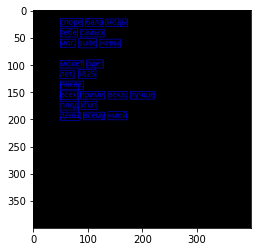

predict=[{'boxes': tensor([[ 49.7153,  15.8742,  90.0350,  30.7068],
        [ 97.1034,  15.5150, 128.9448,  30.6621],
        [ 98.8094,  92.2465, 129.7331, 106.8613],
        [ 83.6710,  53.4199, 115.5710,  69.2380],
        [133.9485,  16.7325, 173.1370,  30.9387],
        [ 92.1870, 187.1202, 131.8930, 202.1169],
        [ 50.5139,  34.0369,  81.5576,  49.5151],
        [ 88.9750, 167.1603, 116.8117, 182.6195],
        [ 87.2715,  35.2747, 130.7498,  50.0813],
        [137.2506, 187.3442, 172.5489, 201.4457],
        [177.7216, 149.4434, 223.0137, 163.4484],
        [ 51.1559, 129.6678,  93.2187, 145.2941],
        [ 49.3554, 110.6814,  75.4878, 125.6938],
        [ 50.5101,  53.5527,  77.6280,  69.0975],
        [ 50.5559,  93.0099,  91.7482, 106.3933],
        [ 49.7627, 187.2514,  86.3390, 202.7155],
        [137.7485, 149.1794, 172.0383, 163.7249],
        [ 50.5446, 148.3569,  80.9113, 164.0005],
        [ 50.1171, 168.0580,  83.4828, 183.7046],
        [122.9157,  54.0848, 16

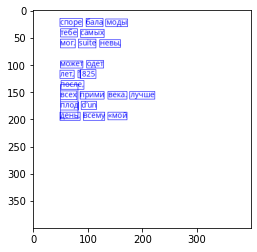

predict=[{'boxes': tensor([[ 50.0689,  16.4172,  91.1715,  30.5561],
        [133.9718,  17.1597, 173.1648,  30.7770],
        [ 96.9889,  15.9912, 128.8619,  29.8232],
        [ 92.2757, 187.4461, 131.5241, 201.5944],
        [137.9085, 187.3690, 173.2639, 200.7328],
        [ 50.3202,  33.9250,  81.6344,  48.9504],
        [ 49.7030, 187.4180,  85.9267, 202.1178],
        [ 98.2231,  92.3961, 130.0975, 106.4449],
        [ 50.5466, 129.7771,  93.1983, 144.8424],
        [123.1412,  54.6292, 160.6370,  67.7837],
        [ 83.7545,  53.6688, 115.5194,  68.4601],
        [137.6741, 149.5534, 172.4245, 163.1490],
        [178.1749, 149.6527, 222.8579, 162.8553],
        [ 49.8929, 111.0446,  75.7274, 125.4125],
        [ 88.8687, 167.3576, 116.4865, 182.4513],
        [ 50.5826,  93.1863,  92.0741, 106.2408],
        [ 85.6373, 149.9641, 130.1617, 163.3402],
        [ 87.1553,  35.4725, 130.6347,  49.8322],
        [ 49.8441, 168.2013,  83.2555, 183.6861],
        [ 50.2299, 148.4503,  8

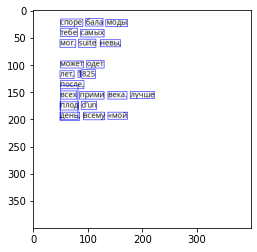

predict=[{'boxes': tensor([[133.6469,  17.2833, 173.4415,  30.9012],
        [ 49.1657,  16.5920,  90.6449,  30.3649],
        [137.7009, 187.5371, 172.8629, 200.9990],
        [ 92.2332, 187.6384, 132.5267, 201.7201],
        [ 96.8145,  15.9854, 129.5435,  29.9322],
        [122.7363,  54.7042, 160.8919,  67.7397],
        [177.8278, 149.5429, 223.1421, 162.7008],
        [ 49.6566, 187.5792,  86.6122, 202.2525],
        [ 88.3897, 167.2614, 116.4476, 182.2453],
        [ 85.2877, 150.0231, 131.1664, 163.2643],
        [ 84.0627,  53.7306, 116.1252,  68.3320],
        [ 98.4427,  92.6800, 130.0203, 106.4508],
        [ 50.3560,  34.1517,  81.3006,  49.2460],
        [ 50.0275,  93.3574,  92.3544, 105.9490],
        [ 50.3617, 148.8313,  80.9697, 163.1110],
        [ 49.6534, 111.1044,  75.7657, 125.3260],
        [137.2166, 149.5719, 171.8372, 163.2014],
        [ 89.1982, 109.0724, 114.0368, 125.4045],
        [ 50.2280, 130.3086,  92.6385, 145.2399],
        [ 49.6392,  54.0529,  7

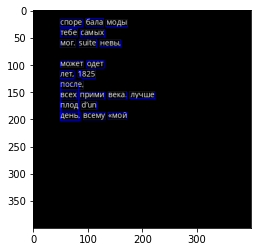

In [13]:
model.eval()


for i,(x,y) in enumerate(data_loader_test):
    img = to_image(x[0])
    x = x[0].to(device)
    predict = model([x])
    #img = np.asarray(img)
    # for box in y[0]['boxes']:
    # #box = y[0]['boxes'].view(-1)
    #     x1 = int(box[0])
    #     y1 = int(box[1])
    #     x2 = int(box[2])
    #     y2 = int(box[3])        
    #     img = cv2.rectangle(np.asarray(img),(x1,y1),(x2,y2),color=(255,0,0))
    print(f'{predict=}')
    for box in predict[0]['boxes']:
    #box = y[0]['boxes'].view(-1)
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])        
        img = cv2.rectangle(np.asarray(img),(x1,y1),(x2,y2),color=(0,0,255))
    #print(img.shape)
    plt.imshow(img)
    plt.show()
    #img.show()
    if i>10:
        break

torch.Size([3, 529, 486])


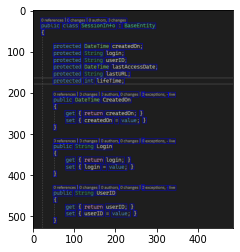

In [32]:
trans = get_transform(False)

#with Image.open("/home/aleksei/MyProject/netology/dll-19/diplom/MyExample/im_20230302_190911.jpg") as img:
with Image.open("/home/aleksei/MyProject/netology/dll-19/diplom/MyExample/im_20230301_181215.jpg") as img:
    img = img.convert('RGB')
    
    img_tensor,target = trans(img,None)
    print(f'{img_tensor.shape}')
    
    img_tensor = img_tensor.to(device)
    
    predict = model([img_tensor])
    
    for box in predict[0]['boxes']:
    #box = y[0]['boxes'].view(-1)
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        img = cv2.rectangle(np.asarray(img),(x1,y1),(x2,y2),color=(0,0,255))
    #print(img.shape)
    plt.imshow(img)
    plt.show()
    
    

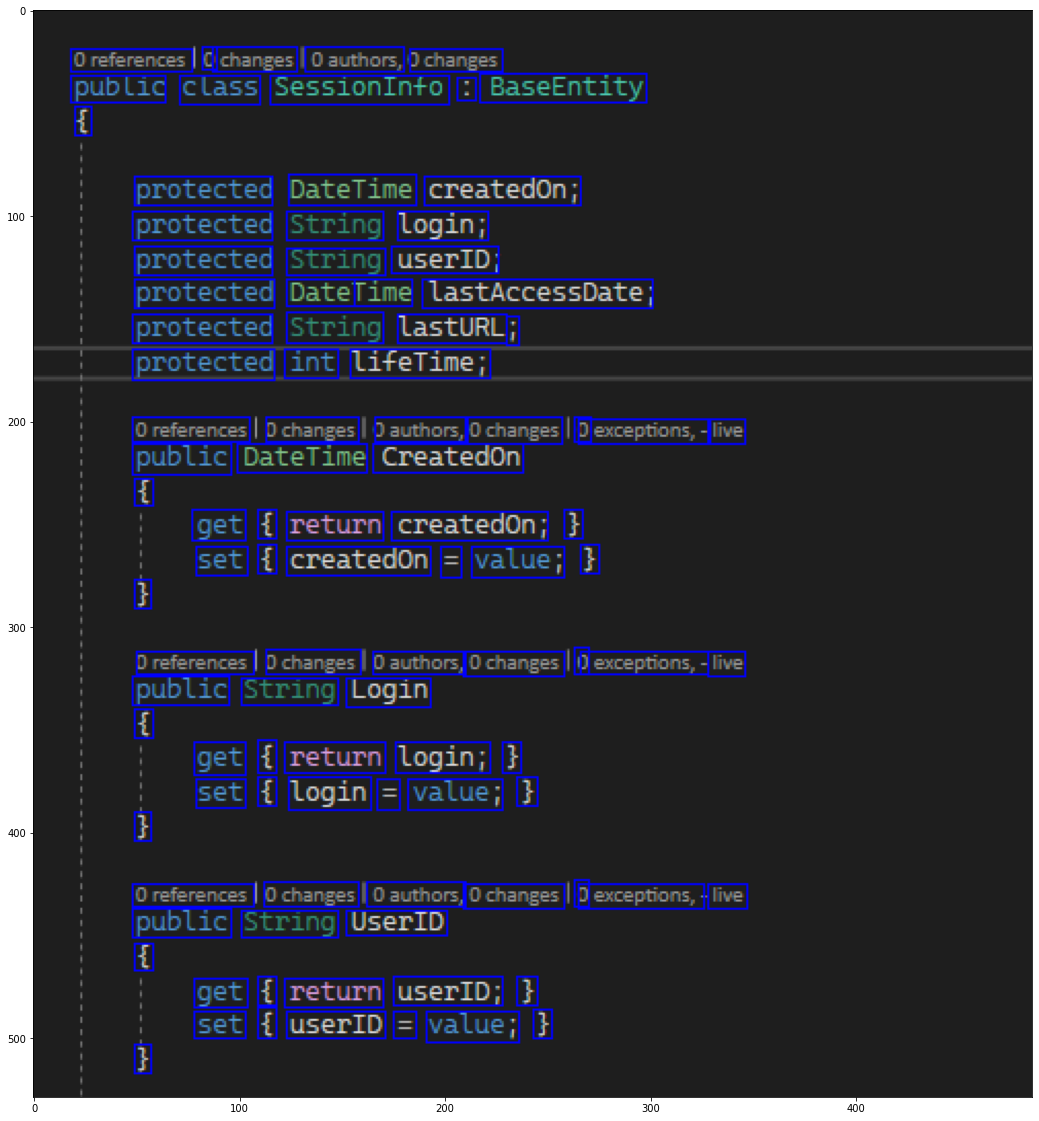

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

## Testing my losses

In [2]:
import os
import PIL
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.tensorboard import SummaryWriter
from MyDataset import MyDataset
from common.engine import train_one_epoch
from common import utils

from train_config_400_1 import configuration as conf_train
from test_config_400_1 import configuration as conf_test

import MyModel as my_model
from util.my_utils import get_array_loss, get_count_box_loss

#params:
# our dataset has two classes only - background and text
num_classes = 2
num_epochs = 100
save_freq = 1
log_folder = 'output/logs/data_f_rcnn_stable'
save_dir = 'output/model'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 6


dataset = MyDataset(conf_train, is_train=True)
dataset_test = MyDataset(conf_test, is_train=False)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

path = 'output/model/FastRCNN_resnet50_1.pth'
data_loader_test

print(f'testing_model {path=}')
model = my_model.load_model(path, num_classes, device)
model.to(device)
model.eval()
losses = []
with torch.no_grad():    
    for images, targets in data_loader_test:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predicts = model(images)
        
        array_loss = get_array_loss(torch.cat(list(map(lambda m:m["boxes"],predicts)))
               , torch.cat(list(map(lambda m:m["boxes"],targets))))
        print(f'{array_loss=}')
        
        count_box_loss = get_count_box_loss(torch.FloatTensor(list(map(lambda m:len(m["boxes"]),predicts))),
            torch.FloatTensor(list(map(lambda m:len(m["boxes"]),targets))))
        
        print(f'{count_box_loss=}')
        
        break

/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


testing_model path='output/model/FastRCNN_resnet50_1.pth'
Loading from output/model/FastRCNN_resnet50_1.pth
array_loss=tensor(142524.4688, device='cuda:0')
count_box_loss=tensor(111.)


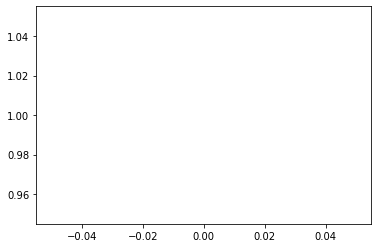

In [1]:
import matplotlib.pyplot as plt
plt.plot([1])

In [63]:
import matplotlib.pyplot as plt
import cv2
import torchvision

to_image = torchvision.transforms.ToPILImage()

img_array = to_image(images[0].detach().cpu())#.permute(1,2,0).numpy()

#img_array = img_array.astype(np.)
#image_show = img_array.copy()
#image_show = np.ascontiguousarray(image_show[:, :, ::-1])
#img = image_show.copy()
for box in predicts[0]['boxes']:
    #box = y[0]['boxes'].view(-1)
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        img_array = cv2.rectangle(np.asarray(img_array),(x1,y1),(x2,y2),color=(0,0,255))
        #cv2.imwrite('output/testing_image/img_2.jpg',img)
    #print(img.shape)

cv2.imwrite('output/testing_image/img_1.png',cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))
#cv2.imwrite('output/testing_image/img_1.png', cv2.cvtColor(image_show, cv2.COLOR_RGBA2BGRA),cv2.IMREAD_UNCHANGED)
#cv2.imwrite('output/testing_image/img_1.png', image_show, [cv2.IMREAD_UNCHANGED])
    
#plt.figure(figsize=(10,10))    
#plt.imsave('output/testing_image/img_1.jpg',np.asarray(image_show).astype(np.uint8))
#plt.imsave('output/testing_image/img_1.jpg',image_show)
#plt.imshow(img_array)
#plt.show()

True

In [42]:
from util.my_utils import get_array_loss
print(f'{len(predicts[0]["boxes"])=}, {len(targets[0]["boxes"])}')

get_array_loss(predicts[0]['boxes'] , targets[0]["boxes"])
get_array_loss(torch.cat(list(map(lambda m:m["boxes"],predicts)))
               , torch.cat(list(map(lambda m:m["boxes"],targets))))


#mse = torch.nn.MSELoss()

#mse(len(predicts[0]["boxes"])*1.0,len(targets[0]["boxes"])*1.0)


len(predicts[0]["boxes"])=29, 23


tensor(183022.6406, device='cuda:0')

In [22]:
mse(torch.FloatTensor(list(map(lambda m:len(m["boxes"]),predicts))),
torch.FloatTensor(list(map(lambda m:len(m["boxes"]),targets))))

tensor(84.3333)

In [41]:
#torch.FloatTensor()
torch.cat(list(map(lambda m:m["boxes"],targets)))

#targets[0]["boxes"]

torch.Size([138, 4])